In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [2]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

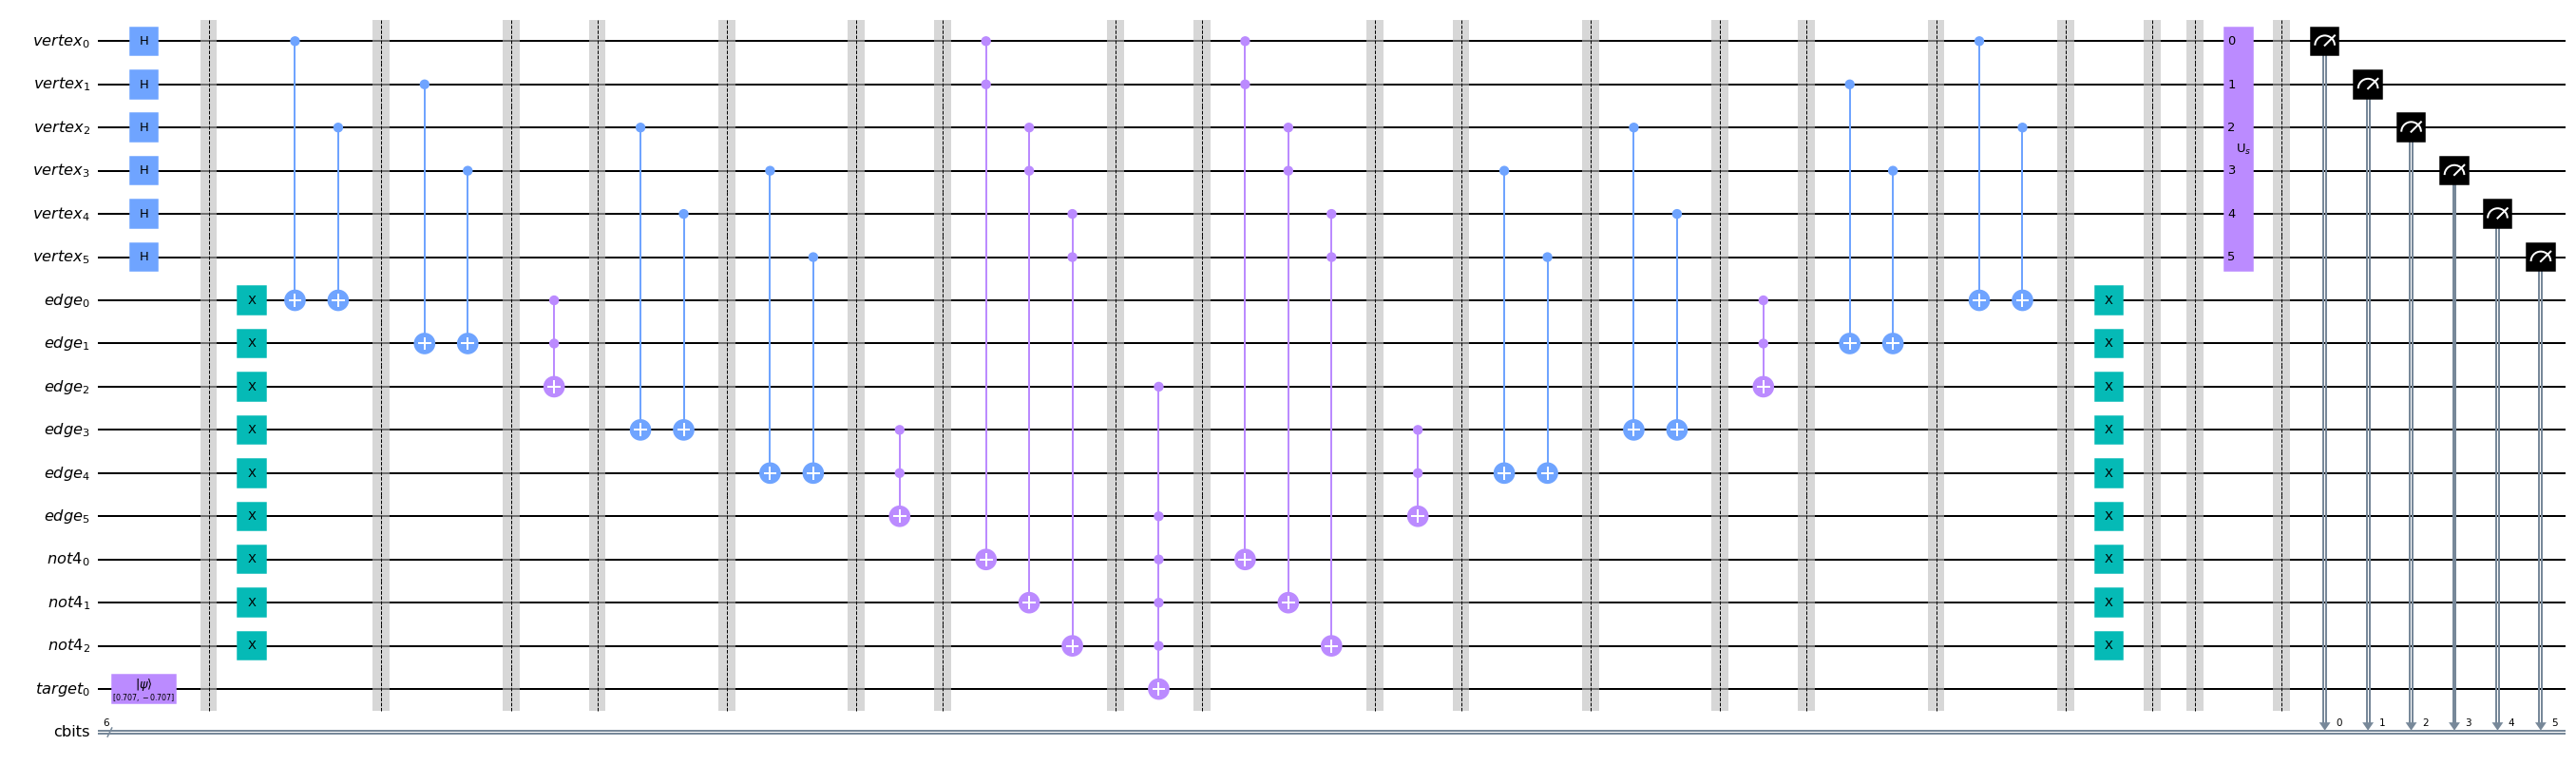

In [4]:
#example (v為vertex, e為edge)
v_list = [0,1,2]
e_list = [[0,1], [1,2]]

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')
# choose n prob.
top_n = 9

qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#oracle
vertexcolor_oracle(qc, v_list, e_list)
qc.barrier()

#diffuser
qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)
"""
#oracle
vertexcolor_oracle(qc, v_list, e_list)
qc.barrier()

#diffuser
qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
qc.barrier()
"""

#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

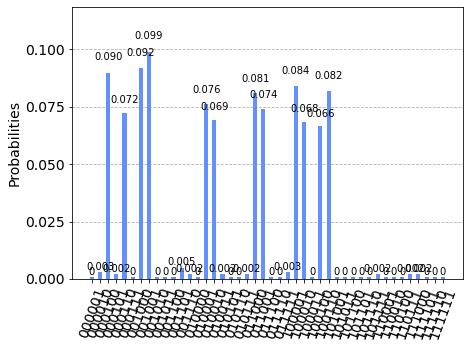

In [5]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [6]:
print(counts)

{'101110': 1, '011110': 1, '101101': 1, '101100': 1, '001101': 5, '000001': 1, '111111': 1, '100010': 70, '010010': 71, '011111': 3, '110010': 1, '010110': 1, '001010': 1, '000010': 3, '100100': 68, '101011': 1, '011000': 83, '100001': 86, '000101': 2, '010011': 2, '010001': 78, '000100': 92, '000110': 74, '111000': 2, '100110': 84, '001000': 94, '111101': 1, '011001': 76, '011100': 1, '110001': 1, '001001': 101, '110111': 2, '000111': 1, '111110': 1, '010111': 2, '100011': 1, '001110': 2, '110100': 1, '001011': 1, '010101': 1, '101111': 2, '001100': 1, '010000': 1, '101001': 1}


[['001001', 101], ['001000', 94], ['000100', 92], ['100001', 86], ['100110', 84], ['011000', 83], ['010001', 78], ['011001', 76], ['000110', 74], ['010010', 71], ['100010', 70], ['100100', 68], ['001101', 5], ['011111', 3], ['000010', 3], ['000101', 2], ['010011', 2], ['111000', 2], ['110111', 2], ['010111', 2], ['001110', 2], ['101111', 2], ['101110', 1], ['011110', 1], ['101101', 1], ['101100', 1], ['000001', 1], ['111111', 1], ['110010', 1], ['010110', 1], ['001010', 1], ['101011', 1], ['111101', 1], ['011100', 1], ['110001', 1], ['000111', 1], ['111110', 1], ['100011', 1], ['110100', 1], ['001011', 1], ['010101', 1], ['001100', 1], ['010000', 1], ['101001', 1]]


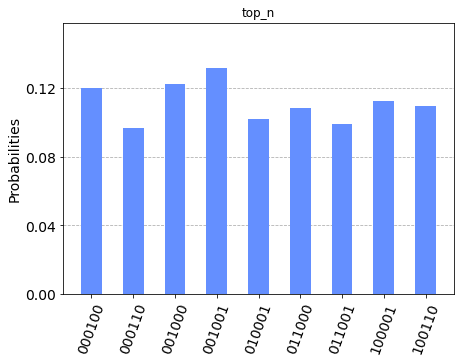

In [9]:
p1 = []
p2 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)